In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture

from utils import get_data, draw_ellipse

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('data/CC GENERAL.csv')
X.drop(columns=['CUST_ID'], inplace=True)
X.ffill(inplace=True)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# Split data into train and test sets.

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, _, _ = train_test_split(X, X, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Apply PCA with 2 components and GMM

In [4]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 2
N_JOBS = -1

scaler = StandardScaler()
dim_redn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [5]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the score based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with PCA, Dry Beans')

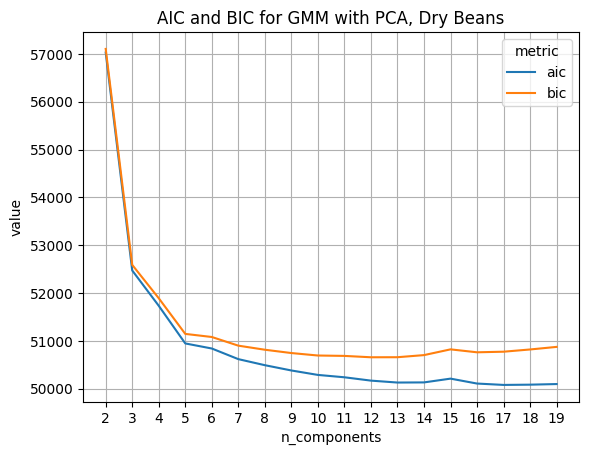

In [6]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with PCA, Dry Beans')

<Axes: title={'center': 'Score of GMM with PCA, Dry Beans'}, xlabel='n_components'>

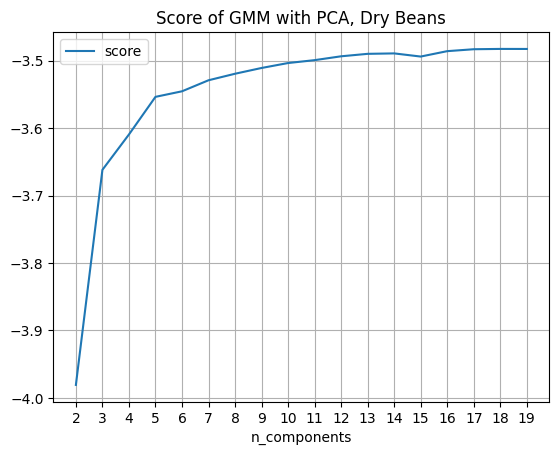

In [7]:
results_df.plot(x='n_components', y='score',title='Score of GMM with PCA, Dry Beans', xticks=results_df['n_components'], grid=True)

In [8]:
# Get the PCA transformed data
X_pca = clus_pipeline[:-1].transform(X_train)
X_pca.shape

(7160, 2)

In [9]:
#  Get the Exp Max labels and means
clus_pipeline.set_params(model__n_components=6)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.4 / weights.max()


(7160,)


Text(0.5, 1.0, 'GaussMix(6) clustering with PCA(2), Dry Beans')

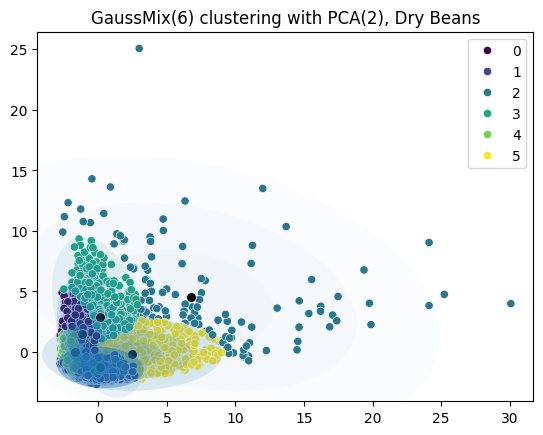

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(6) clustering with PCA(2), Dry Beans")


# Apply ICA with 2 components and GMM

In [12]:
RANDOM_STATE = 42
ICA_N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = FastICA(n_components=ICA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [13]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the core based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with ICA, Dry Beans')

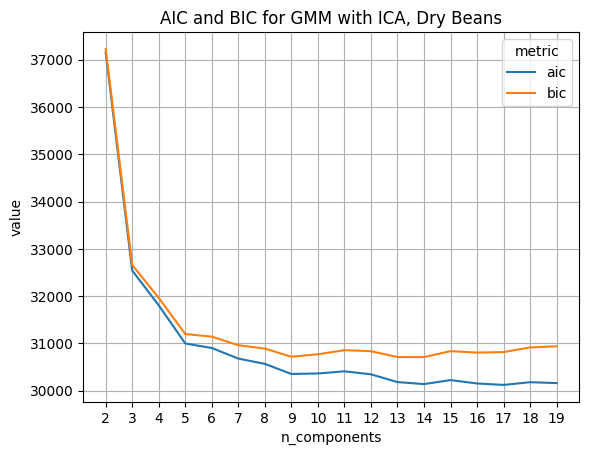

In [14]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with ICA, Dry Beans')

<Axes: title={'center': 'Score of GMM with PCA, Dry Beans'}, xlabel='n_components'>

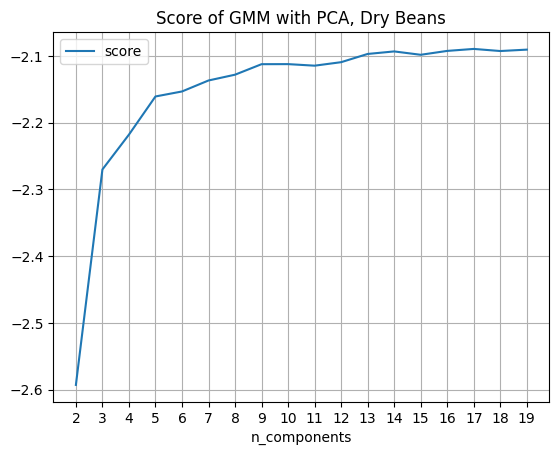

In [15]:
results_df.plot(x='n_components', y='score',title='Score of GMM with PCA, Dry Beans', xticks=results_df['n_components'], grid=True)

In [16]:
# Get the ICA transformed data
X_ica = clus_pipeline[:-1].transform(X_train)
X_ica.shape

(7160, 2)

In [17]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_components=6)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.4 / weights.max()

(7160,)


Text(0.5, 1.0, 'GaussMix(6) clustering with ICA(2), Dry Beans')

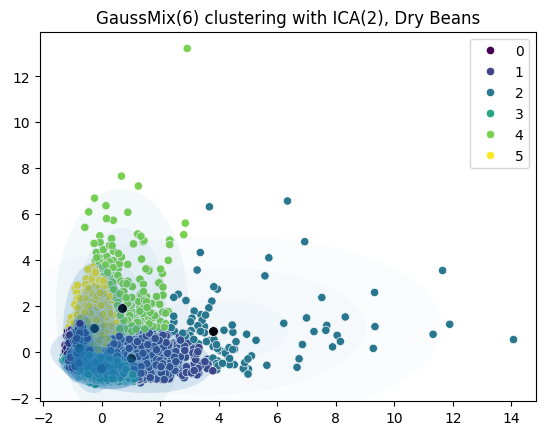

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_ica[:,0], y=X_ica[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(6) clustering with ICA(2), Dry Beans")


# Apply Gaussian projection with 2 components and GMM

In [20]:
RANDOM_STATE = 42
N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = GaussianRandomProjection(n_components=2, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])

In [21]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    # calc the core based on the dim reduced data
    X_dr = clus_pipeline[:-1].transform(X_train)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_dr),
                            'bic': clus_pipeline.named_steps['model'].bic(X_dr),
                            'score': clus_pipeline.named_steps['model'].score(X_dr),
                        }


---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with Gaus Rand Proj, Dry Beans')

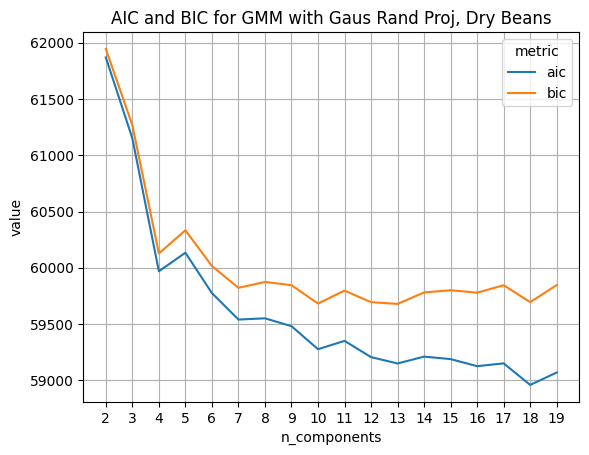

In [22]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with Gaus Rand Proj, Dry Beans')

<Axes: title={'center': 'Score of GMM with Gaus Rand Proj, Dry Beans'}, xlabel='n_components'>

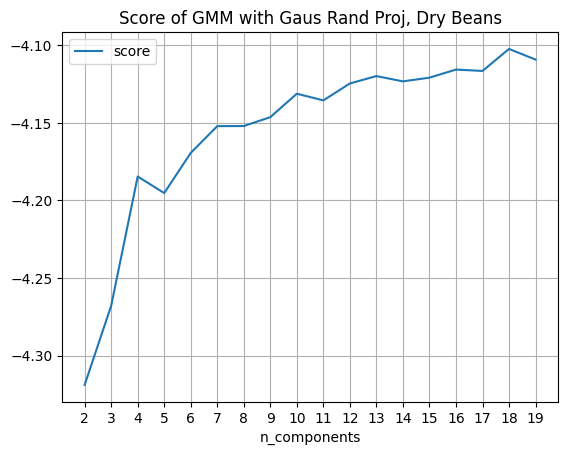

In [23]:
results_df.plot(x='n_components', y='score',title='Score of GMM with Gaus Rand Proj, Dry Beans', xticks=results_df['n_components'], grid=True)

In [24]:
# Get the Gauss Rand Proj transformed data
X_rand = clus_pipeline[:-1].fit_transform(X_train)
X_rand.shape

(7160, 2)

In [25]:
#  Get the K-means labels and centroids
clus_pipeline.set_params(model__n_components=6)

label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.4 / weights.max()

(7160,)


Text(0.5, 1.0, 'GMM(6) clustering with Gaus Rand Proj(2), Dry Beans')

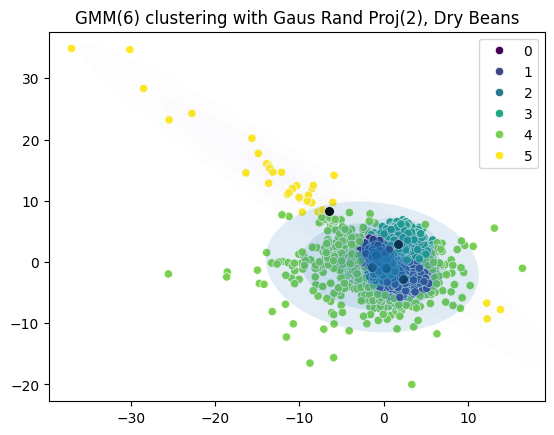

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_rand[:,0], y=X_rand[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GMM(6) clustering with Gaus Rand Proj(2), Dry Beans")

# Apply t-SNE

In [27]:
RANDOM_STATE = 42
T_SNE_N_COMPONENTS = 2

scaler = StandardScaler()
dim_redn = TSNE(n_components=T_SNE_N_COMPONENTS, random_state=RANDOM_STATE)
clus = GaussianMixture(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
])



In [28]:
X_tsne = dr_pipeline.fit_transform(X_train)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [29]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    model =  GaussianMixture(random_state=RANDOM_STATE, n_components=n_components)
    model.fit(X_tsne)
        
    results[n_components] = {'aic': model.aic(X_tsne),
                            'bic': model.bic(X_tsne),
                            'score': model.score(X_tsne),
                        }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


Text(0.5, 1.0, 'AIC and BIC for GMM with TSNE, Dry Beans')

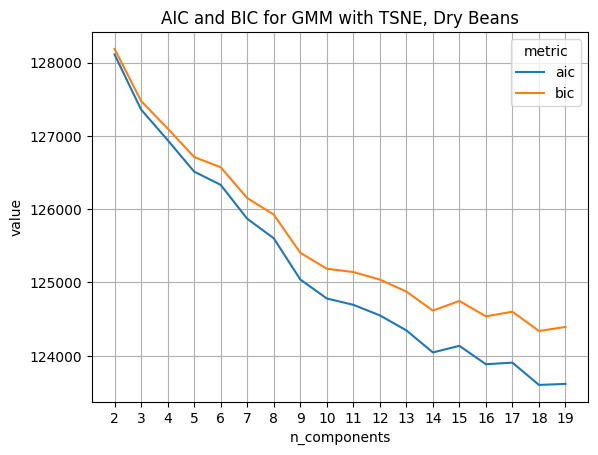

In [30]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score']

plot_df = results_df.melt(id_vars='n_components', var_name='metric', value_name='value').query('metric in ["aic", "bic"]')
ax = sns.lineplot(plot_df, x='n_components', y='value', hue='metric')
ax.set_xticks(results_df['n_components'])
ax.grid()
ax.set_title('AIC and BIC for GMM with TSNE, Dry Beans')

<Axes: title={'center': 'Score of GMM with TSNE, Dry Beans'}, xlabel='n_components'>

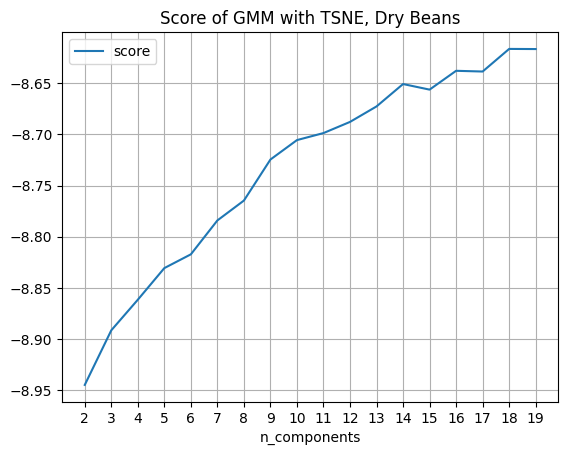

In [31]:
results_df.plot(x='n_components', y='score',title='Score of GMM with TSNE, Dry Beans', xticks=results_df['n_components'], grid=True)

In [32]:
#  Get the K-means labels and centroids
model =  GaussianMixture(random_state=RANDOM_STATE, n_components=6)
label = model.fit_predict(X_tsne)

print(label.shape)

means = model.means_
covariances = model.covariances_
weights = model.weights_

w_factor = 0.2 / weights.max()

(7160,)


Text(0.5, 1.0, 'GaussMix(6) clustering with TSNE(2), Dry Beans')

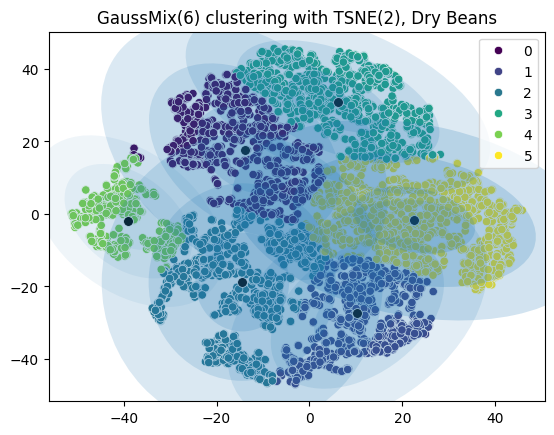

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(6) clustering with TSNE(2), Dry Beans")
